In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
content_path = "tip_1.jpg"
content2_path = "tip_2.jpg"
style_path =   "vvg.jpg"
style2_path = "ue.jpg"


In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

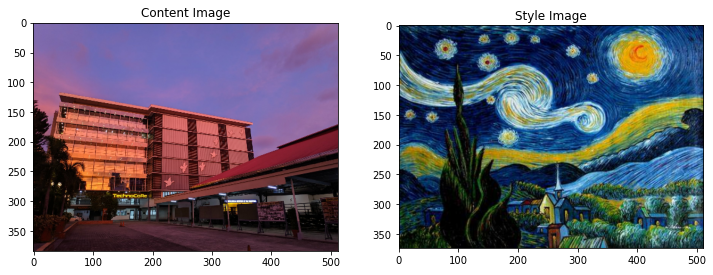

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


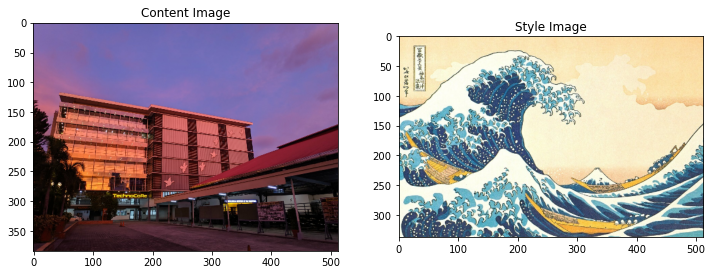

In [9]:
content2_image = load_img(content2_path)
style2_image = load_img(style2_path)

plt.subplot(1, 2, 1)
imshow(content2_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style2_image, 'Style Image')

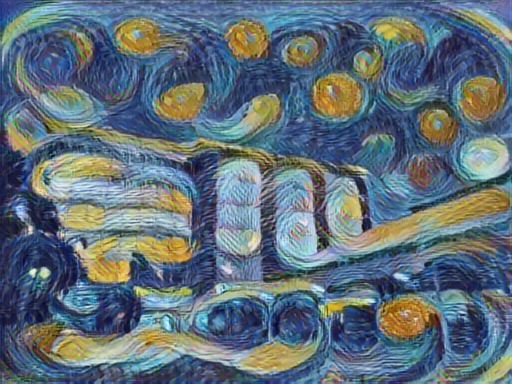

In [10]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)


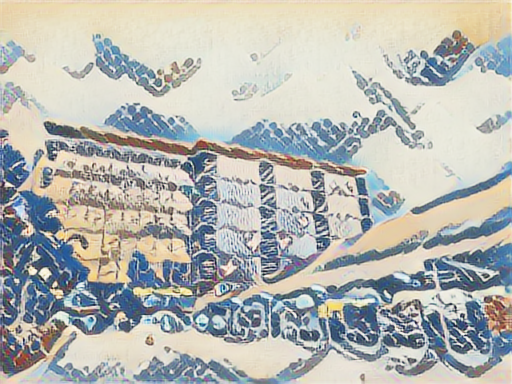

In [11]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized2_image = hub_model(tf.constant(content2_image), tf.constant(style2_image))[0]
tensor_to_image(stylized2_image)


In [12]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape


TensorShape([1, 1000])

In [13]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('cinema', 0.2946153),
 ('library', 0.0405019),
 ('fire_engine', 0.039418656),
 ('planetarium', 0.037683703),
 ('freight_car', 0.032800376)]

In [14]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)




input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [15]:
content_layers = ['block5_conv2'] 

content2_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

style2_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

num_content2_layers = len(content2_layers)
num_style2_layers = len(style2_layers)

In [16]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model


In [17]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


In [18]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [19]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style2_layers, content2_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style2_layers + content2_layers)
    self.style2_layers = style2_layers
    self.content2_layers = content2_layers
    self.num_style2_layers = len(style2_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style2_outputs, content2_outputs = (outputs[:self.num_style2_layers],
                                      outputs[self.num_style2_layers:])

    style2_outputs = [gram_matrix(style2_output)
                     for style2_output in style2_outputs]

    content2_dict = {content2_name: value
                    for content2_name, value
                    in zip(self.content2_layers, content2_outputs)}

    style2_dict = {style2_name: value
                  for style2_name, value
                  in zip(self.style2_layers, style2_outputs)}

    return {'content': content2_dict, 'style': style2_dict}

In [20]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0043622446
    max:  18652.803
    mean:  720.94574

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  142128.67
    mean:  19088.027

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.069893636
    max:  477494.84
    mean:  19772.678

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6317187.5
    mean:  304248.03

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  109087.48
    mean:  2228.7

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1108.4445
    mean:  16.152258


In [21]:
extractor2 = StyleContentModel(style2_layers, content_layers)

results2 = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0043622446
    max:  18652.803
    mean:  720.94574

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  142128.67
    mean:  19088.027

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.069893636
    max:  477494.84
    mean:  19772.678

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6317187.5
    mean:  304248.03

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  109087.48
    mean:  2228.7

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1108.4445
    mean:  16.152258


In [22]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image1 = tf.Variable(content_image)

style2_targets = extractor2(style2_image)['style']
content2_targets = extractor2(content2_image)['content']
image2 = tf.Variable(content2_image)

In [23]:
def clip_0_1(image1):
  return tf.clip_by_value(image1, clip_value_min=0.0, clip_value_max=1.0)

def clip_0_1(image2):
  return tf.clip_by_value(image2, clip_value_min=0.0, clip_value_max=1.0)

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style2_weight=1e-2
content2_weight=1e4
def style2_content2_loss2(outputs2):
    style2_outputs2 = outputs2['style']
    content2_outputs2 = outputs2['content']
    style2_loss = tf.add_n([tf.reduce_mean((style2_outputs2[name]-style2_targets[name])**2) 
                           for name in style2_outputs2.keys()])
    style2_loss *= style2_weight / num_style2_layers

    content2_loss = tf.add_n([tf.reduce_mean((content2_outputs2[name]-content2_targets[name])**2) 
                             for name in content2_outputs2.keys()])
    content2_loss *= content2_weight / num_content2_layers
    loss2 = style2_loss + content2_loss
    return loss2

In [25]:
@tf.function()
def train1_step(image1):
  with tf.GradientTape() as tape:
    outputs = extractor(image1)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image1)
  opt.apply_gradients([(grad, image1)])
  image1.assign(clip_0_1(image1))

@tf.function()
def train2_step(image2):
  with tf.GradientTape() as tape:
    outputs2 = extractor2(image2)
    loss2 = style2_content2_loss2(outputs2)

  grad2 = tape.gradient(loss2, image2)
  opt.apply_gradients([(grad2, image2)])
  image2.assign(clip_0_1(image2))


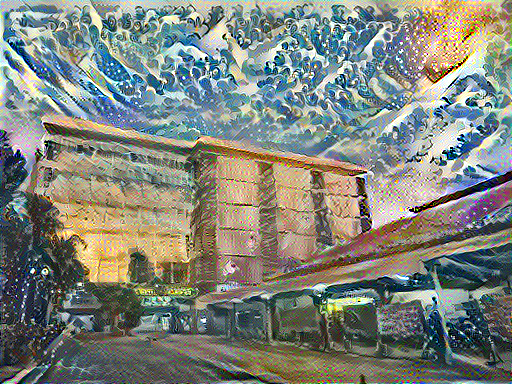

Train step: 1000
Total time: 1112.7


In [26]:
train2_step(image2)
train2_step(image2)
train2_step(image2)
tensor_to_image(image2)

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train2_step(image2)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image2))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


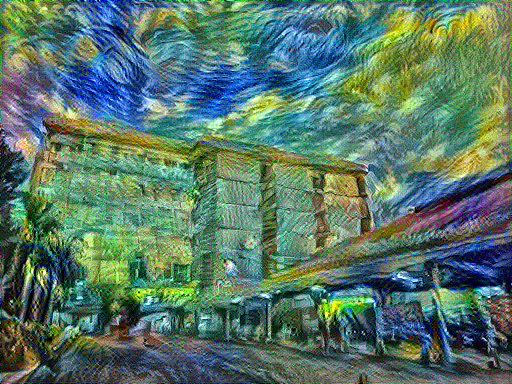

Train step: 400
..........................................

In [ ]:
train1_step(image1)
train1_step(image1)
train1_step(image1)
tensor_to_image(image1)

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train1_step(image1)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image1))
  print("Train step: {}".format(step))

end = time.time() 
print("Total time: {:.1f}".format(end-start))


In [ ]:
file_name = 'stylized_image_1.png'
tensor_to_image(image1).save(file_name)
file_name = 'stylized_image_2.png'
tensor_to_image(image2).save(file_name)